In [3]:
pip install pennylane qiskit qiskit_machine_learning scikit-learn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Created wheel for fastdtw: filename=fastdtw-0.3.4-py3-none-any.whl size=3565 sha256=457c2b04fc1bde292257a4ae6d45e32e0a848afa7e8b2e40d51f7ae423319601
  Stored in directory: /Users/krethik/Library/Caches/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install  qiskit_machine_learning

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC

Confusion Matrix:
[[48  2]
 [ 3 47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        50
           1       0.96      0.94      0.95        50

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



ValueError: X has 101 features, but SVC is expecting 100 features as input.

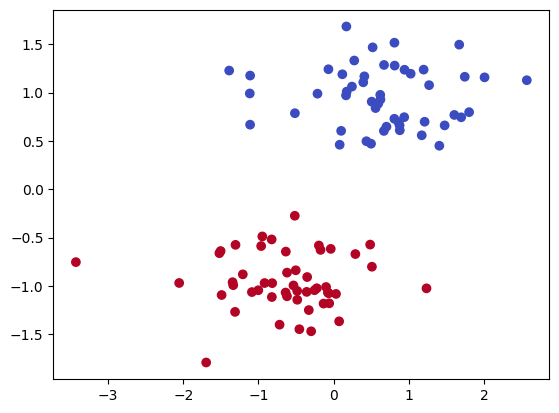

In [6]:
# Generate random data points
X, y = make_blobs(n_samples=100, centers=2, random_state=6)

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define a quantum device
n_qubits = 2
dev = qml.device('default.qubit', wires=n_qubits)

# Create a quantum feature map
def feature_map(x):
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    for i in range(n_qubits):
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits):
        for j in range(i + 1, n_qubits):
            qml.CNOT(wires=[i, j])
            qml.RZ((np.pi - x[i]) * (np.pi - x[j]), wires=j)
            qml.CNOT(wires=[i, j])

# Create the quantum kernel
@qml.qnode(dev)
def kernel(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

# Create the kernel matrix
def quantum_kernel_matrix(X):
    n_samples = len(X)
    kernel_matrix = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            kernel_matrix[i, j] = kernel(X[i], X[j])[0]
    return kernel_matrix

# Compute the quantum kernel matrix
quantum_kernel = quantum_kernel_matrix(X)

# Train the classical SVC with the quantum kernel
svc = SVC(kernel='precomputed')
svc.fit(quantum_kernel, y)

# Predict the classes of the test set using the quantum kernel
y_pred = svc.predict(quantum_kernel)

# Print the classification report and confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))
print("Classification Report:")
print(classification_report(y, y_pred))

# Plot the decision boundary
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm')

# Create a mesh to plot the decision boundary
xx, yy = np.meshgrid(np.linspace(min(X[:, 0]), max(X[:, 0]), 100),
                     np.linspace(min(X[:, 1]), max(X[:, 1]), 100))
xy = np.c_[xx.ravel(), yy.ravel()]

# Compute the decision function over the mesh
Z = np.array([svc.decision_function(quantum_kernel_matrix(np.vstack([x, X]))) for x in xy])
Z = Z[:, 0].reshape(xx.shape)

# Plot the decision boundary and margins
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])
plt.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1],
            s=100, facecolors='none', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Quantum SVM Decision Boundary with Support Vectors')
plt.show()

